In [2]:
import torch
import torchvision
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
# Display
import os
from IPython.display import Image, display
import matplotlib.cm as cm
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, GlobalAveragePooling2D, Input, Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/home/jupyter-anthony/miniconda3/envs/cxr_work/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-12-05 11:45:38.746311: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-05 11:45:38.876097: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-05 11:45:39.400644: W tensorflow/compiler/xla/stream_exe

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [6]:
#from keras.applications.resnet import ResNet50, preprocess_input
# Recreate the exact same model, including its weights and the optimizer
#model_path = 'saved_models/densenet_All_white_detection_LR-0.0001_20221205-054121_epoch_003_val_loss_0.23216.h5'
model_path = 'saved_models/densenet_All_survive_detection_LR-0.0001_20221205-010809_epoch_002_val_loss_0.63442.h5'
disease = 'All'
task = 'survive' #'white' #'survive' # race
num_class = 3 if task == 'race' else 2
model_name = 'densenet'
#'saved_models/ResNet50_All_race_detection_LR-0.001_20221204-034954_epoch_005_val_loss_0.49068.h5'

try:
  # Specify an invalid GPU device
  with tf.device('/GPU:1'):
    
    HEIGHT = 256
    WIDTH = 256

    def define_densenet_model(n_classes=3, input_shape=(224,224,3)):
        base_model = tf.keras.applications.densenet.DenseNet121(weights=None, include_top=False, input_shape=input_shape)
        x = AveragePooling2D(pool_size=(3,3), name='avg_pool')(base_model.output)
        x = Flatten()(x)
        x = Dense(1024, activation='relu', name='dense_post_pool')(x)
        x = Dropout(0.2)(x)
        output = Dense(n_classes, activation='softmax', name='predictions')(x)
        model = Model(inputs=base_model.input, outputs=output)
        
        return model

    if model_name == 'densenet':
        HEIGHT = 224
        WIDTH = 224
        model = define_densenet_model(num_class) #define_densenet_model()
        preprocess_input = tf.keras.applications.densenet.preprocess_input
        last_conv_layer = 'conv5_block16_2_conv'
    elif model_name == 'resnet50':
        input_a = Input(shape=(HEIGHT, WIDTH, 3))
        base_model = tf.keras.applications.resnet.ResNet50(weights='imagenet', 
                            input_tensor=input_a,
                            include_top=False, 
                            input_shape=(HEIGHT, WIDTH, 3)
                            )

        x = GlobalAveragePooling2D()(base_model.output)
        x = Dense(num_class, name='dense_logits')(x)
        output = Activation('softmax', dtype='float32', name='predictions')(x)
        model = Model(inputs=[input_a], outputs=[output])
        preprocess_input = tf.keras.applications.resnet.preprocess_input
        for layer in base_model.layers: # keep base_model aside from training
            layer.trainable = False
        
        last_conv_layer = 'conv5_block3_3_conv' #for ResNet50
    
    model.load_weights(model_path)
except RuntimeError as e:
  print(e)

2022-12-05 11:48:06.259889: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-05 11:48:08.829090: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12994 MB memory:  -> device: 0, name: GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6
2022-12-05 11:48:08.830022: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21858 MB memory:  -> device: 1, name: GeForce RTX 3090, pci bus id: 0000:b3:00.0, compute capability: 8.6


In [4]:
def get_gradcam (img_array, model, last_conv_layer_name, height = 224, pred_index=None, alpha=1):
    """the shape of input img_array should be [height,height,3]
    """
    img = np.expand_dims(img_array, axis=0) # add one batch_size
    
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    #print(model.output.shape)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8((height -1) * heatmap)
    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(height))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    
    jet_heatmap = jet_heatmap.resize((img_array.shape[1], img_array.shape[0]))
    
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    
    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img_array
    return superimposed_img, jet_heatmap

In [5]:
def load_image(img_path, resize=True):
	# convert image from BGR to RGB
  # src = cv2.imread(img_path) 
  # # openCV default is BGR
  # # img = cv2.cvtColor(src, cv2.COLOR_BGR2RGB) # to RGB
  # img_path = f'{DIR}/{file_l[i]}'
  img = keras.preprocessing.image.load_img(img_path, 
                                    target_size= (224,224, 3))
  img = np.array(img)
  return img

# draw a grid of images
def show_sign_grid_from_paths(image_paths):
  images = [load_image(img) for img in image_paths]
# convert numpy array to a single tensor
  images = torch.as_tensor(images)#, dtype=int) 
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=5)
  plt.figure(figsize=(30, 30))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

def show_sign_grid(images, nrow = 5):
  #images = [load_image(img) for img in image_paths]
  images = [np.asarray(im) for im in images]
  # convert numpy array to a single tensor
  images = torch.as_tensor(images)#, dtype=int) 
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=nrow)
  plt.figure(figsize=(30, 30))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                             

In [11]:
last_conv_layer = 'conv5_block16_2_conv'

In [5]:
# load images
from PIL import Image

if task == 'race':
    class_names = ['ASIAN', 'BLACK', 'WHITE']
elif task == 'white':
    class_names = ['NON_WHITE', 'WHITE']
elif task == 'survive':
    class_names = ['DIE', 'SURVIVE'] # order must match folder

data_dir = f'data/{disease}/images/{task}'
for cls in class_names:
    DIR = f'{data_dir}/test/{cls}'
    file_l = os.listdir(DIR)
    

(224, 224, 3)

In [7]:
with tf.device('/GPU:1'):

    gradcam_imgs = []
    data_dir = f'data/{disease}/images/{task}'
    cls = 'DIE' #'WHITE'
    DIR = f'{data_dir}/test/{cls}'
    file_l = os.listdir(DIR)
    file_l = file_l[100:150]
    for fname in tqdm(file_l):
        img_path = f'{DIR}/{fname}'
        img = keras.preprocessing.image.load_img(img_path, 
                                    target_size= (HEIGHT,WIDTH, 3))
        img = np.asarray(img)
        gradcam, jet_heatmap = get_gradcam(img, model, last_conv_layer, alpha=2)
        gradcam_img = keras.preprocessing.image.array_to_img(gradcam)
        gradcam_imgs.append(gradcam_img)
    #show_sign_grid(gradcam_imgs, nrow = 10)
    

2022-12-05 11:48:35.134896: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8500
2022-12-05 11:48:35.627641: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


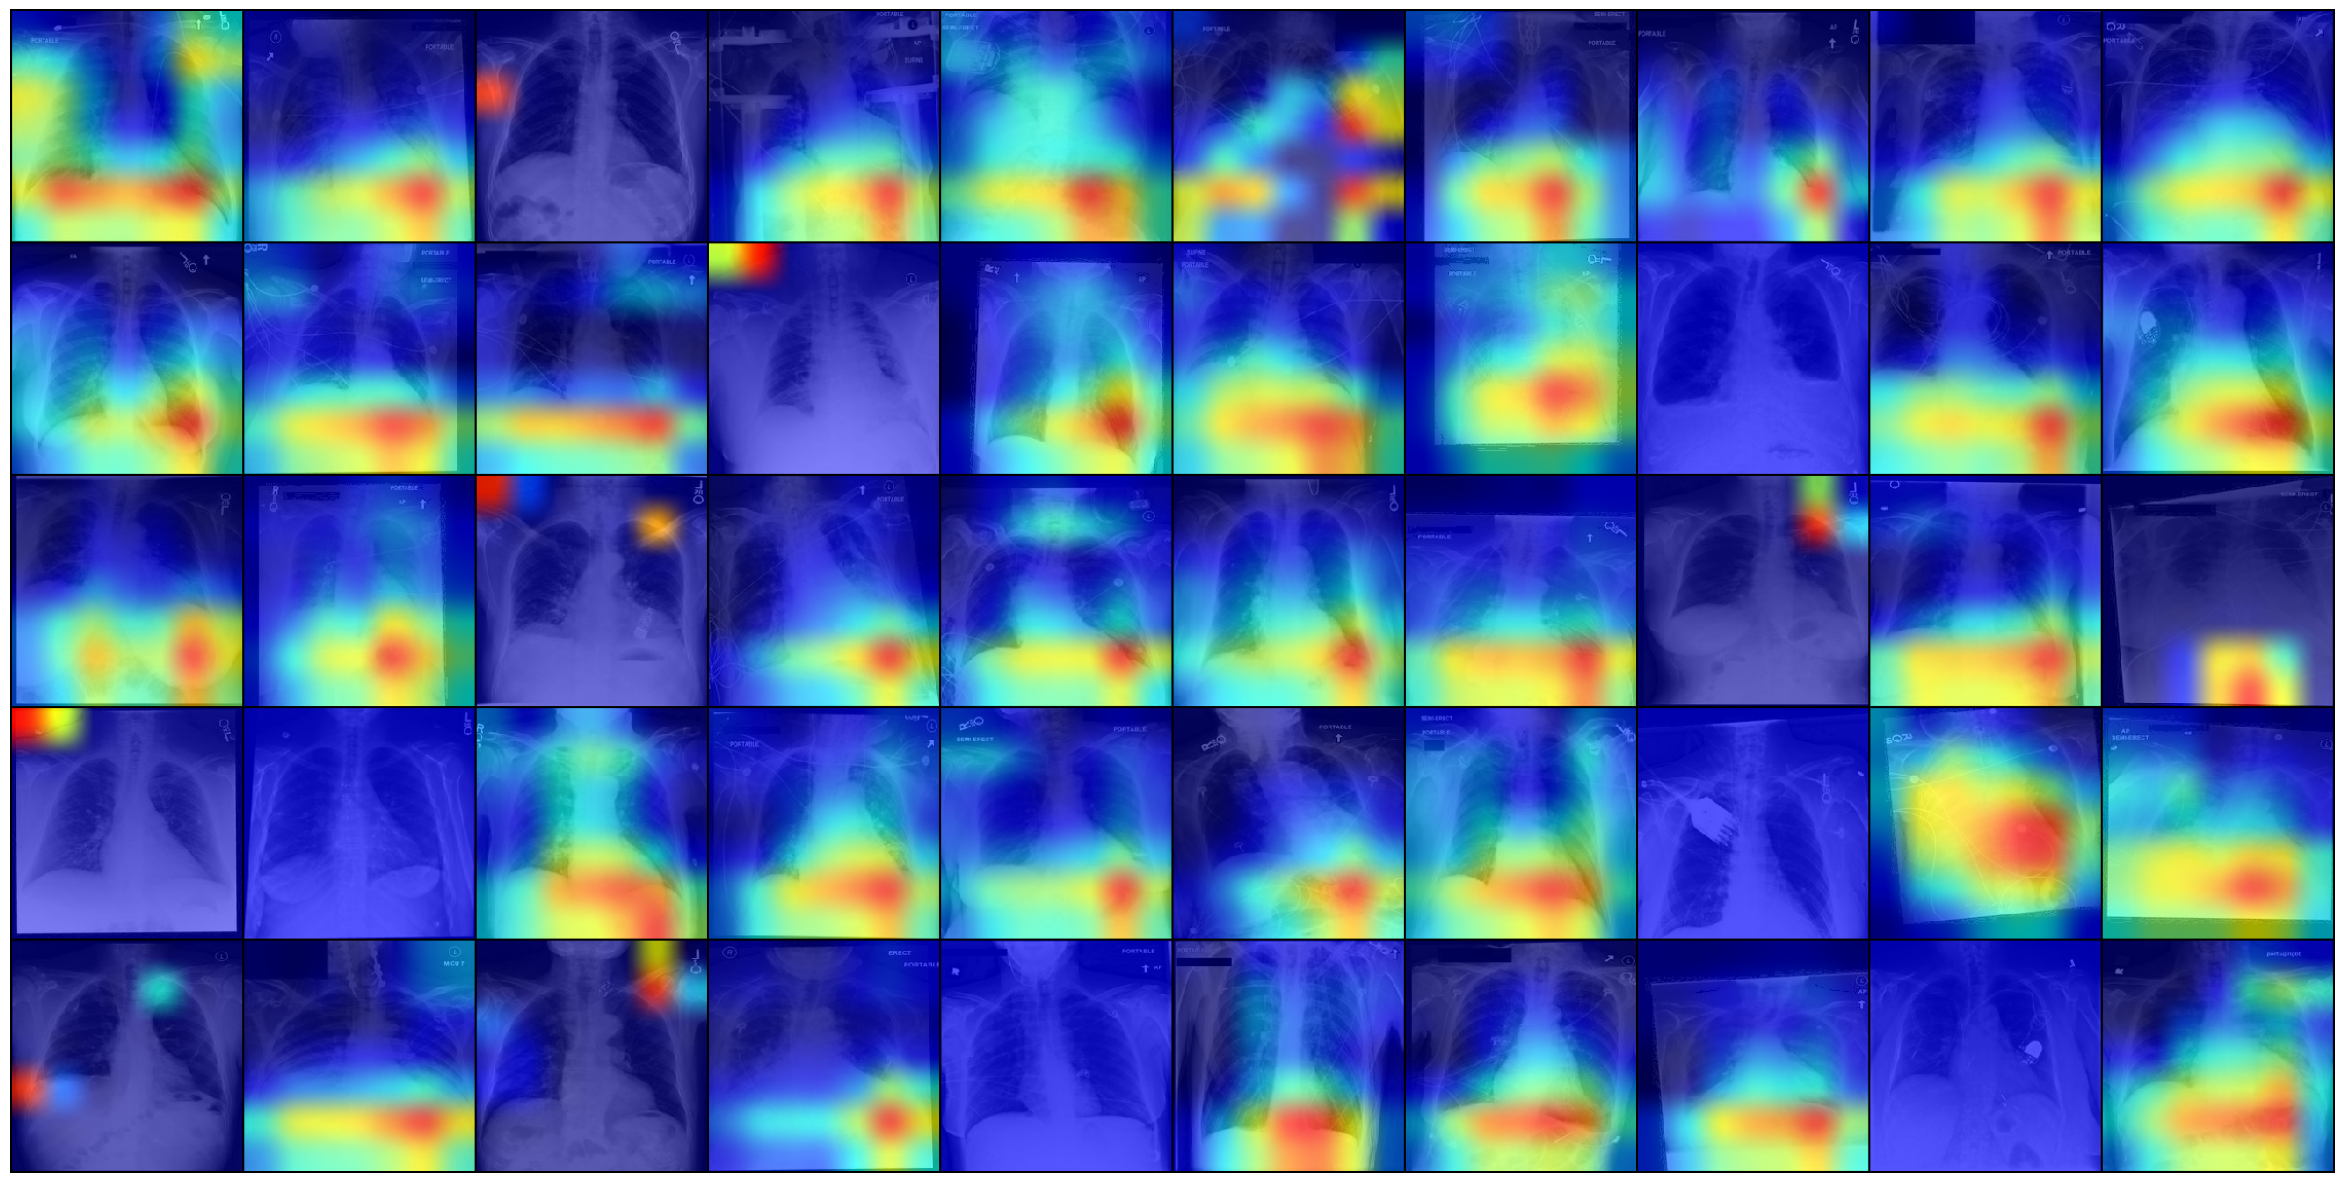

In [22]:
show_sign_grid(gradcam_imgs, nrow = 10)

/tmp/ipykernel_1023/2245881197.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642975993/work/torch/csrc/utils/tensor_new.cpp:230.)
  images = torch.as_tensor(images)#, dtype=int)


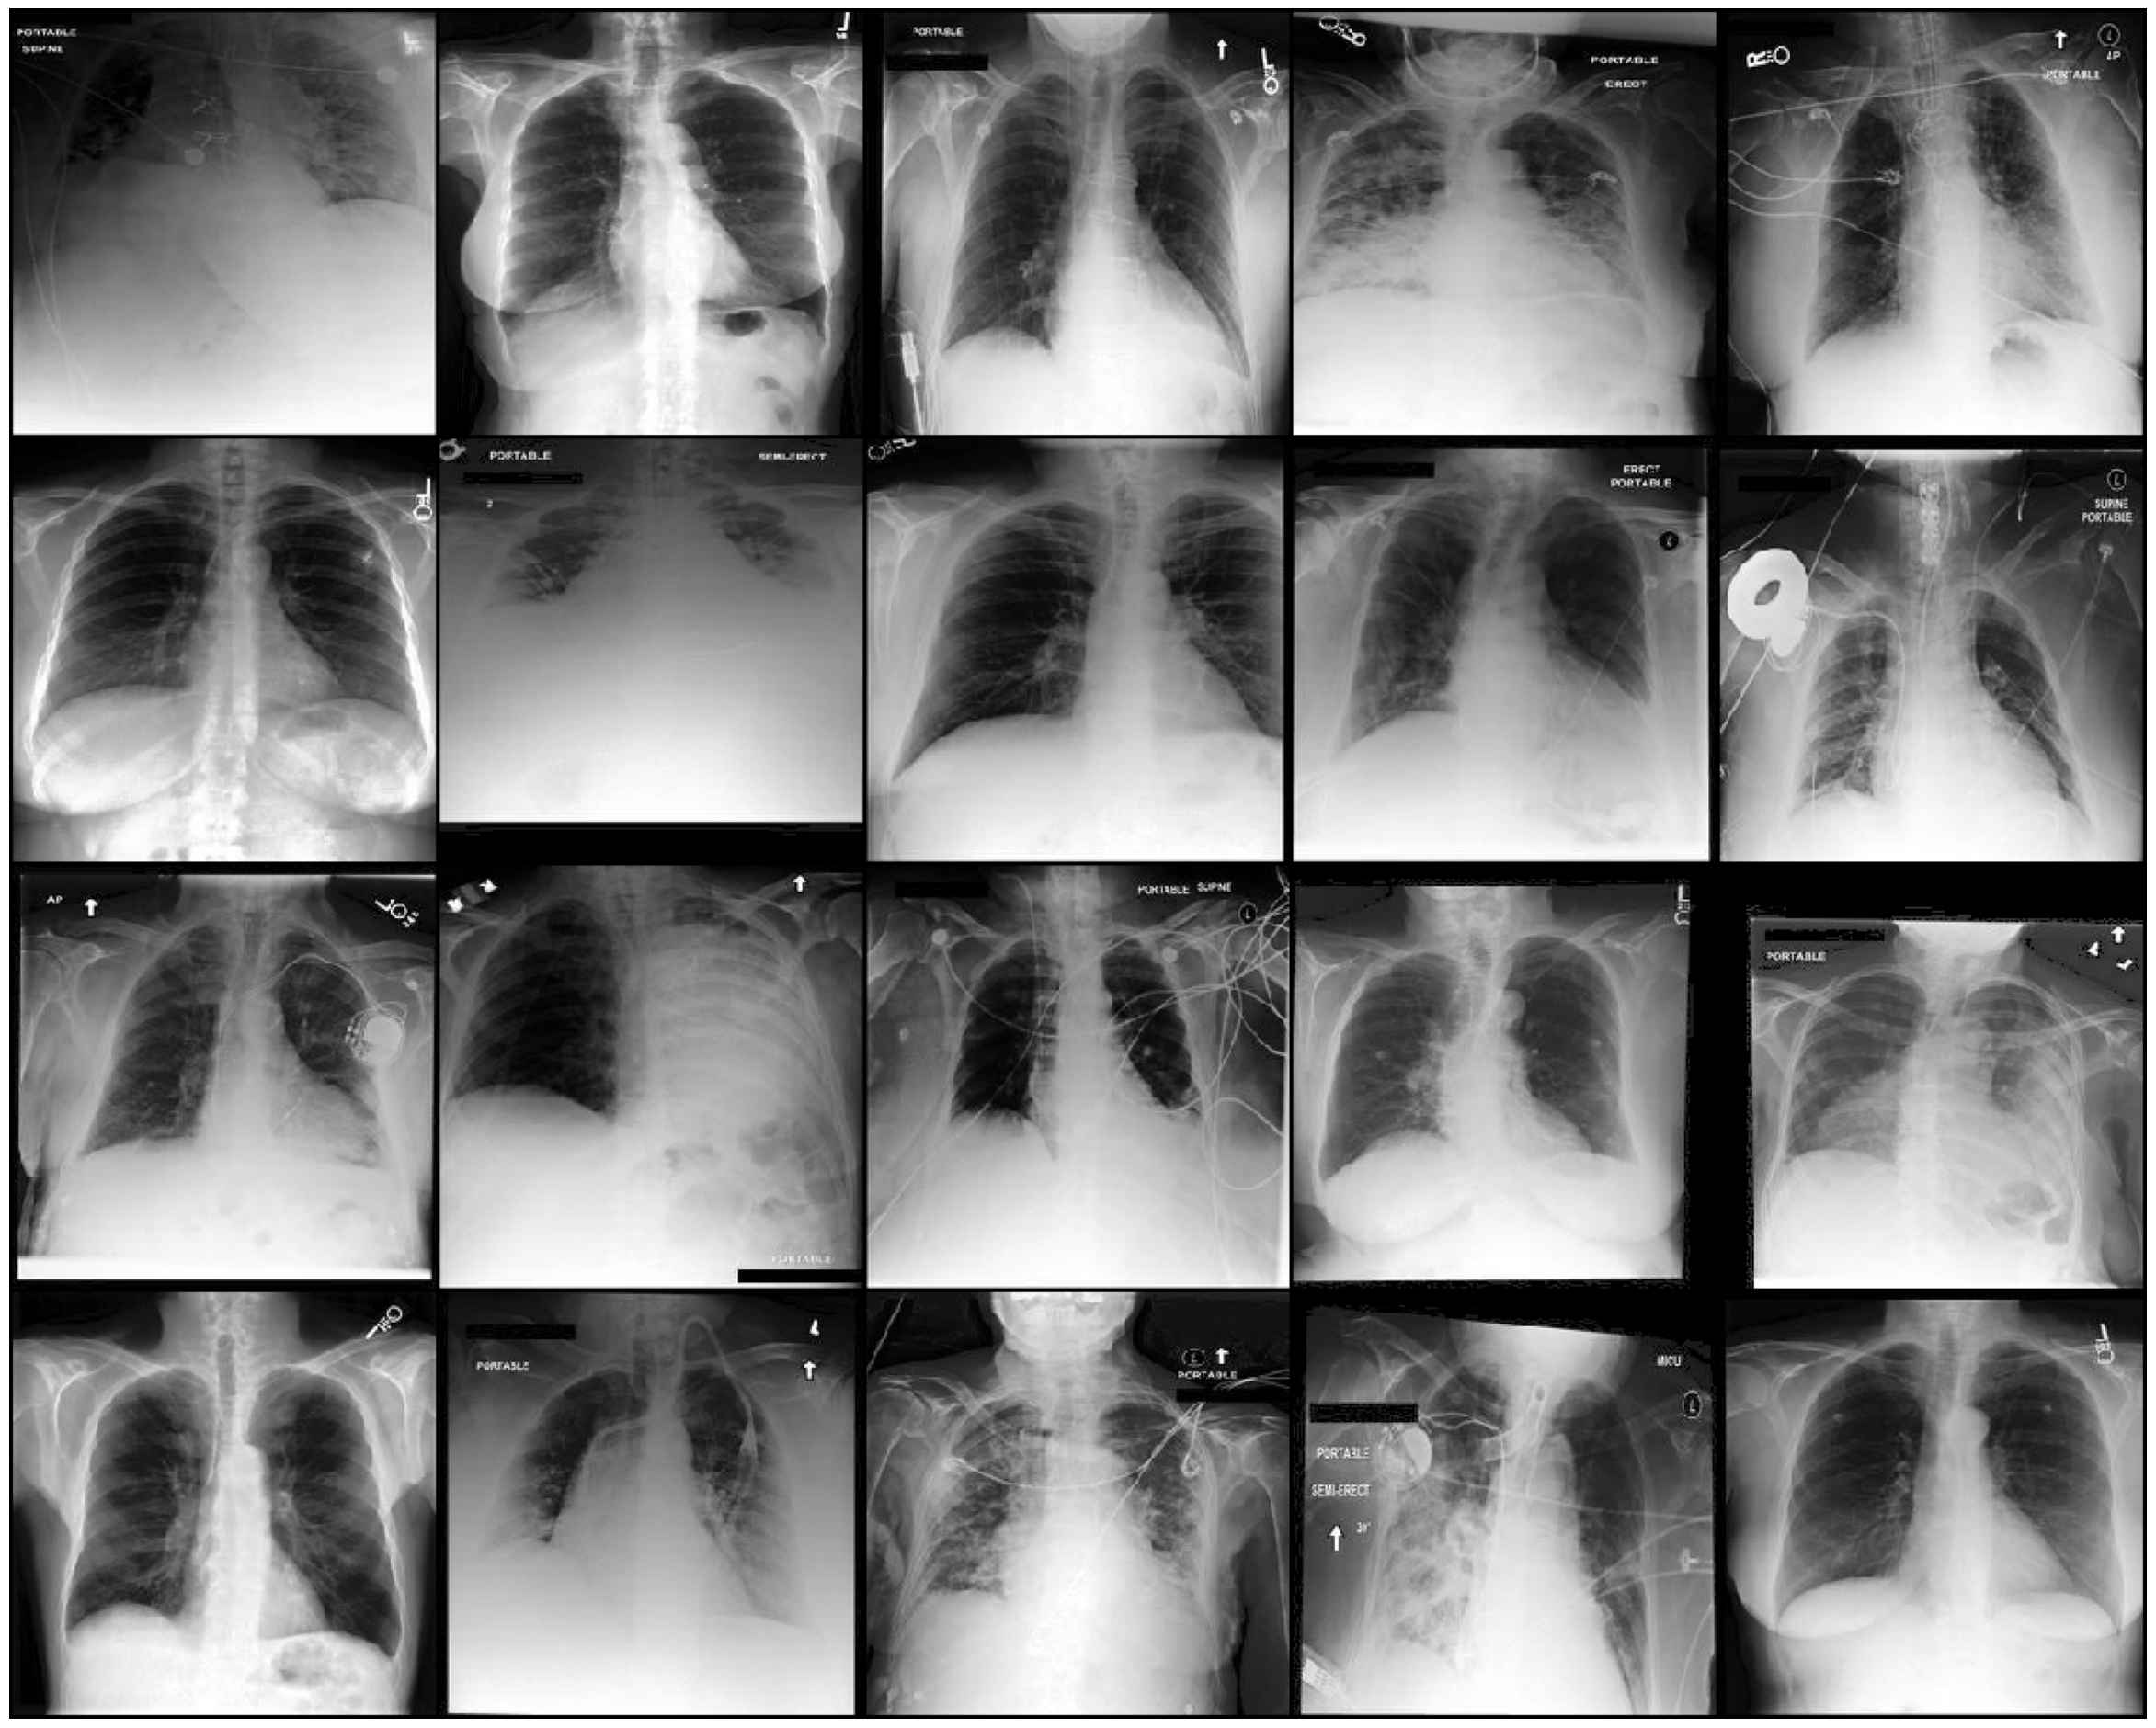

In [5]:
DIR = 'data/All/images/white/test/WHITE'
image_paths = [f'{DIR}/{file}' for file in os.listdir(DIR)]

image_paths = image_paths[:20]
show_sign_grid(image_paths)

In [10]:
img_path = 'data/All/images/white/test/WHITE/116446.jpeg'
img = keras.preprocessing.image.load_img(img_path, 
                                    target_size= (224,224, 3))
                                    #target_size= (HEIGHT,WIDTH, 3))
img = np.asarray(img)
img.shape

(224, 224, 3)

In [11]:
with tf.device('/GPU:1'):
    gradcam, jet_heatmap = gradcam_img(img, model, last_conv_layer, alpha=2)
    gradcam = keras.preprocessing.image.array_to_img(gradcam)
    

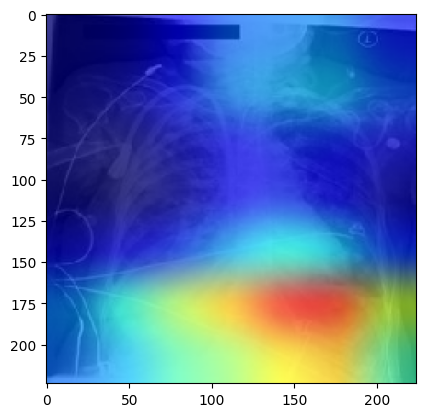

In [12]:
plt.imshow(gradcam)

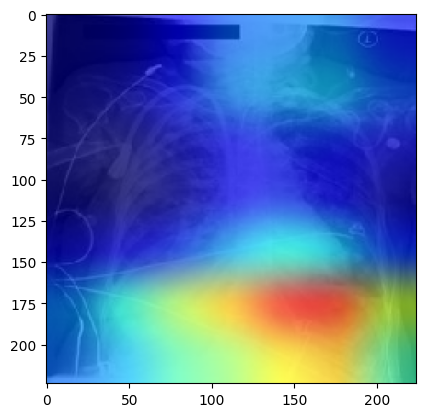

In [38]:
plt.imshow(gradcam)